## Python Web Crawler

In [1]:
from html.parser import HTMLParser  
from urllib.request import urlopen  
from urllib import parse

# Download dir from FTP

Simply Use:
> wget --mirror --continue --no-host-directories --user=username --password=password ftp://hostname/source/path/

# Download Text

http://www.netinstructions.com/how-to-make-a-web-crawler-in-under-50-lines-of-python-code/

In [2]:
# We are going to create a class called LinkParser that inherits some
# methods from HTMLParser which is why it is passed into the definition
class LinkParser(HTMLParser):

    # This is a function that HTMLParser normally has
    # but we are adding some functionality to it
    def handle_starttag(self, tag, attrs):
        # We are looking for the begining of a link. Links normally look
        # like <a href="www.someurl.com"></a>
        if tag == 'a':
            for (key, value) in attrs:
                if key == 'href':
                    # We are grabbing the new URL. We are also adding the
                    # base URL to it. For example:
                    # www.netinstructions.com is the base and
                    # somepage.html is the new URL (a relative URL)
                    #
                    # We combine a relative URL with the base URL to create
                    # an absolute URL like:
                    # www.netinstructions.com/somepage.html
                    newUrl = parse.urljoin(self.baseUrl, value)
                    # And add it to our colection of links:
                    self.links = self.links + [newUrl]

    # This is a new function that we are creating to get links
    # that our spider() function will call
    def getLinks(self, url):
        self.links = []
        # Remember the base URL which will be important when creating
        # absolute URLs
        self.baseUrl = url
        # Use the urlopen function from the standard Python 3 library
        response = urlopen(url)
        # Make sure that we are looking at HTML and not other things that
        # are floating around on the internet (such as
        # JavaScript files, CSS, or .PDFs for example)
        if response.getheader('Content-Type')=='text/html':
            htmlBytes = response.read()
            # Note that feed() handles Strings well, but not bytes
            # (A change from Python 2.x to Python 3.x)
            htmlString = htmlBytes.decode("utf-8")
            self.feed(htmlString)
            return htmlString, self.links
        else:
            return "",[]

In [3]:
from bs4 import BeautifulSoup

def parseHtml_cnfoodsafety(htmlstring):
    soup = BeautifulSoup(htmlstring, "lxml")    
    title = soup.find_all("h1", class_="artical")
    if title == []:
        title = ''
    else:
        title = title[0].get_text()
        
    content = soup.find_all("div", id="artContent")
    if content == []:
        content = ''
    else:
        content = content[0].get_text()
        
    return title, content

In [4]:
from bs4 import BeautifulSoup

def parseHtml_cfsn(htmlstring):
    soup = BeautifulSoup(htmlstring, "lxml")    
    title = soup.find_all("h1")
    if title == []:
        title = ''
    else:
        title = title[0].get_text()
        
    content = soup.find_all("div", id="cont1")
    if content == []:
        content = ''
    else:
        content = content[0].get_text()
        
    return title, content

In [5]:
import pandas as pd

# And finally here is our spider. It takes in an URL, a word to find,
# and the number of pages to search through before giving up
def spider(url, maxPages, pattern):  
    pagesToVisit = [url]
    numberVisited = 0
    pagesVisited = []
    df = pd.DataFrame(columns = ['url', 'date', 'title', 'content'])
    # The main loop. Create a LinkParser and get all the links on the page.
    # Also search the page for the word or string
    # In our getLinks function we return the web page
    # (this is useful for searching for the word)
    # and we return a set of links from that web page
    # (this is useful for where to go next)
    while numberVisited < maxPages and pagesToVisit != []:
        numberVisited = numberVisited +1
        # Start from the beginning of our collection of pages to visit:
        url = pagesToVisit[0]
        pagesToVisit = pagesToVisit[1:]
        #print(pagesToVisit)
        try:
            print(numberVisited, "Visiting:", url)
            parser = LinkParser()
            data, links = parser.getLinks(url)
            if(url.startswith(pattern)):
                date = url[len(pattern) - 2: len(pattern) - 2 + 9 + 1]
                title = ''
                content = ''
                if 'cnfoodsafety' in url:
                    title, content = parseHtml_cnfoodsafety(data)
                elif 'cfsn' in url:
                    title, content = parseHtml_cfsn(data)
                if content != '':
                    df.loc[-1] = [url, date, title, content] # add a row
                    df.index = df.index + 1
            #print(title, content)
                      
            # Add the pages that we visited to the end of our collection of pages to visit:
            # pagesToVisit = pagesToVisit + links   
            for link in links:
                link = link.replace('#SOHUCS','').replace('#comment','')
                if(link.startswith(pattern) and link not in pagesVisited):
                    # pagesToVisit.extend(links)
                    pagesVisited.append(link)
                    pagesToVisit.append(link)
            print(" **Success!**")
        except:
            print(" **Failed!**")
        
    return df

## 中国食品安全网 - 抽检通告

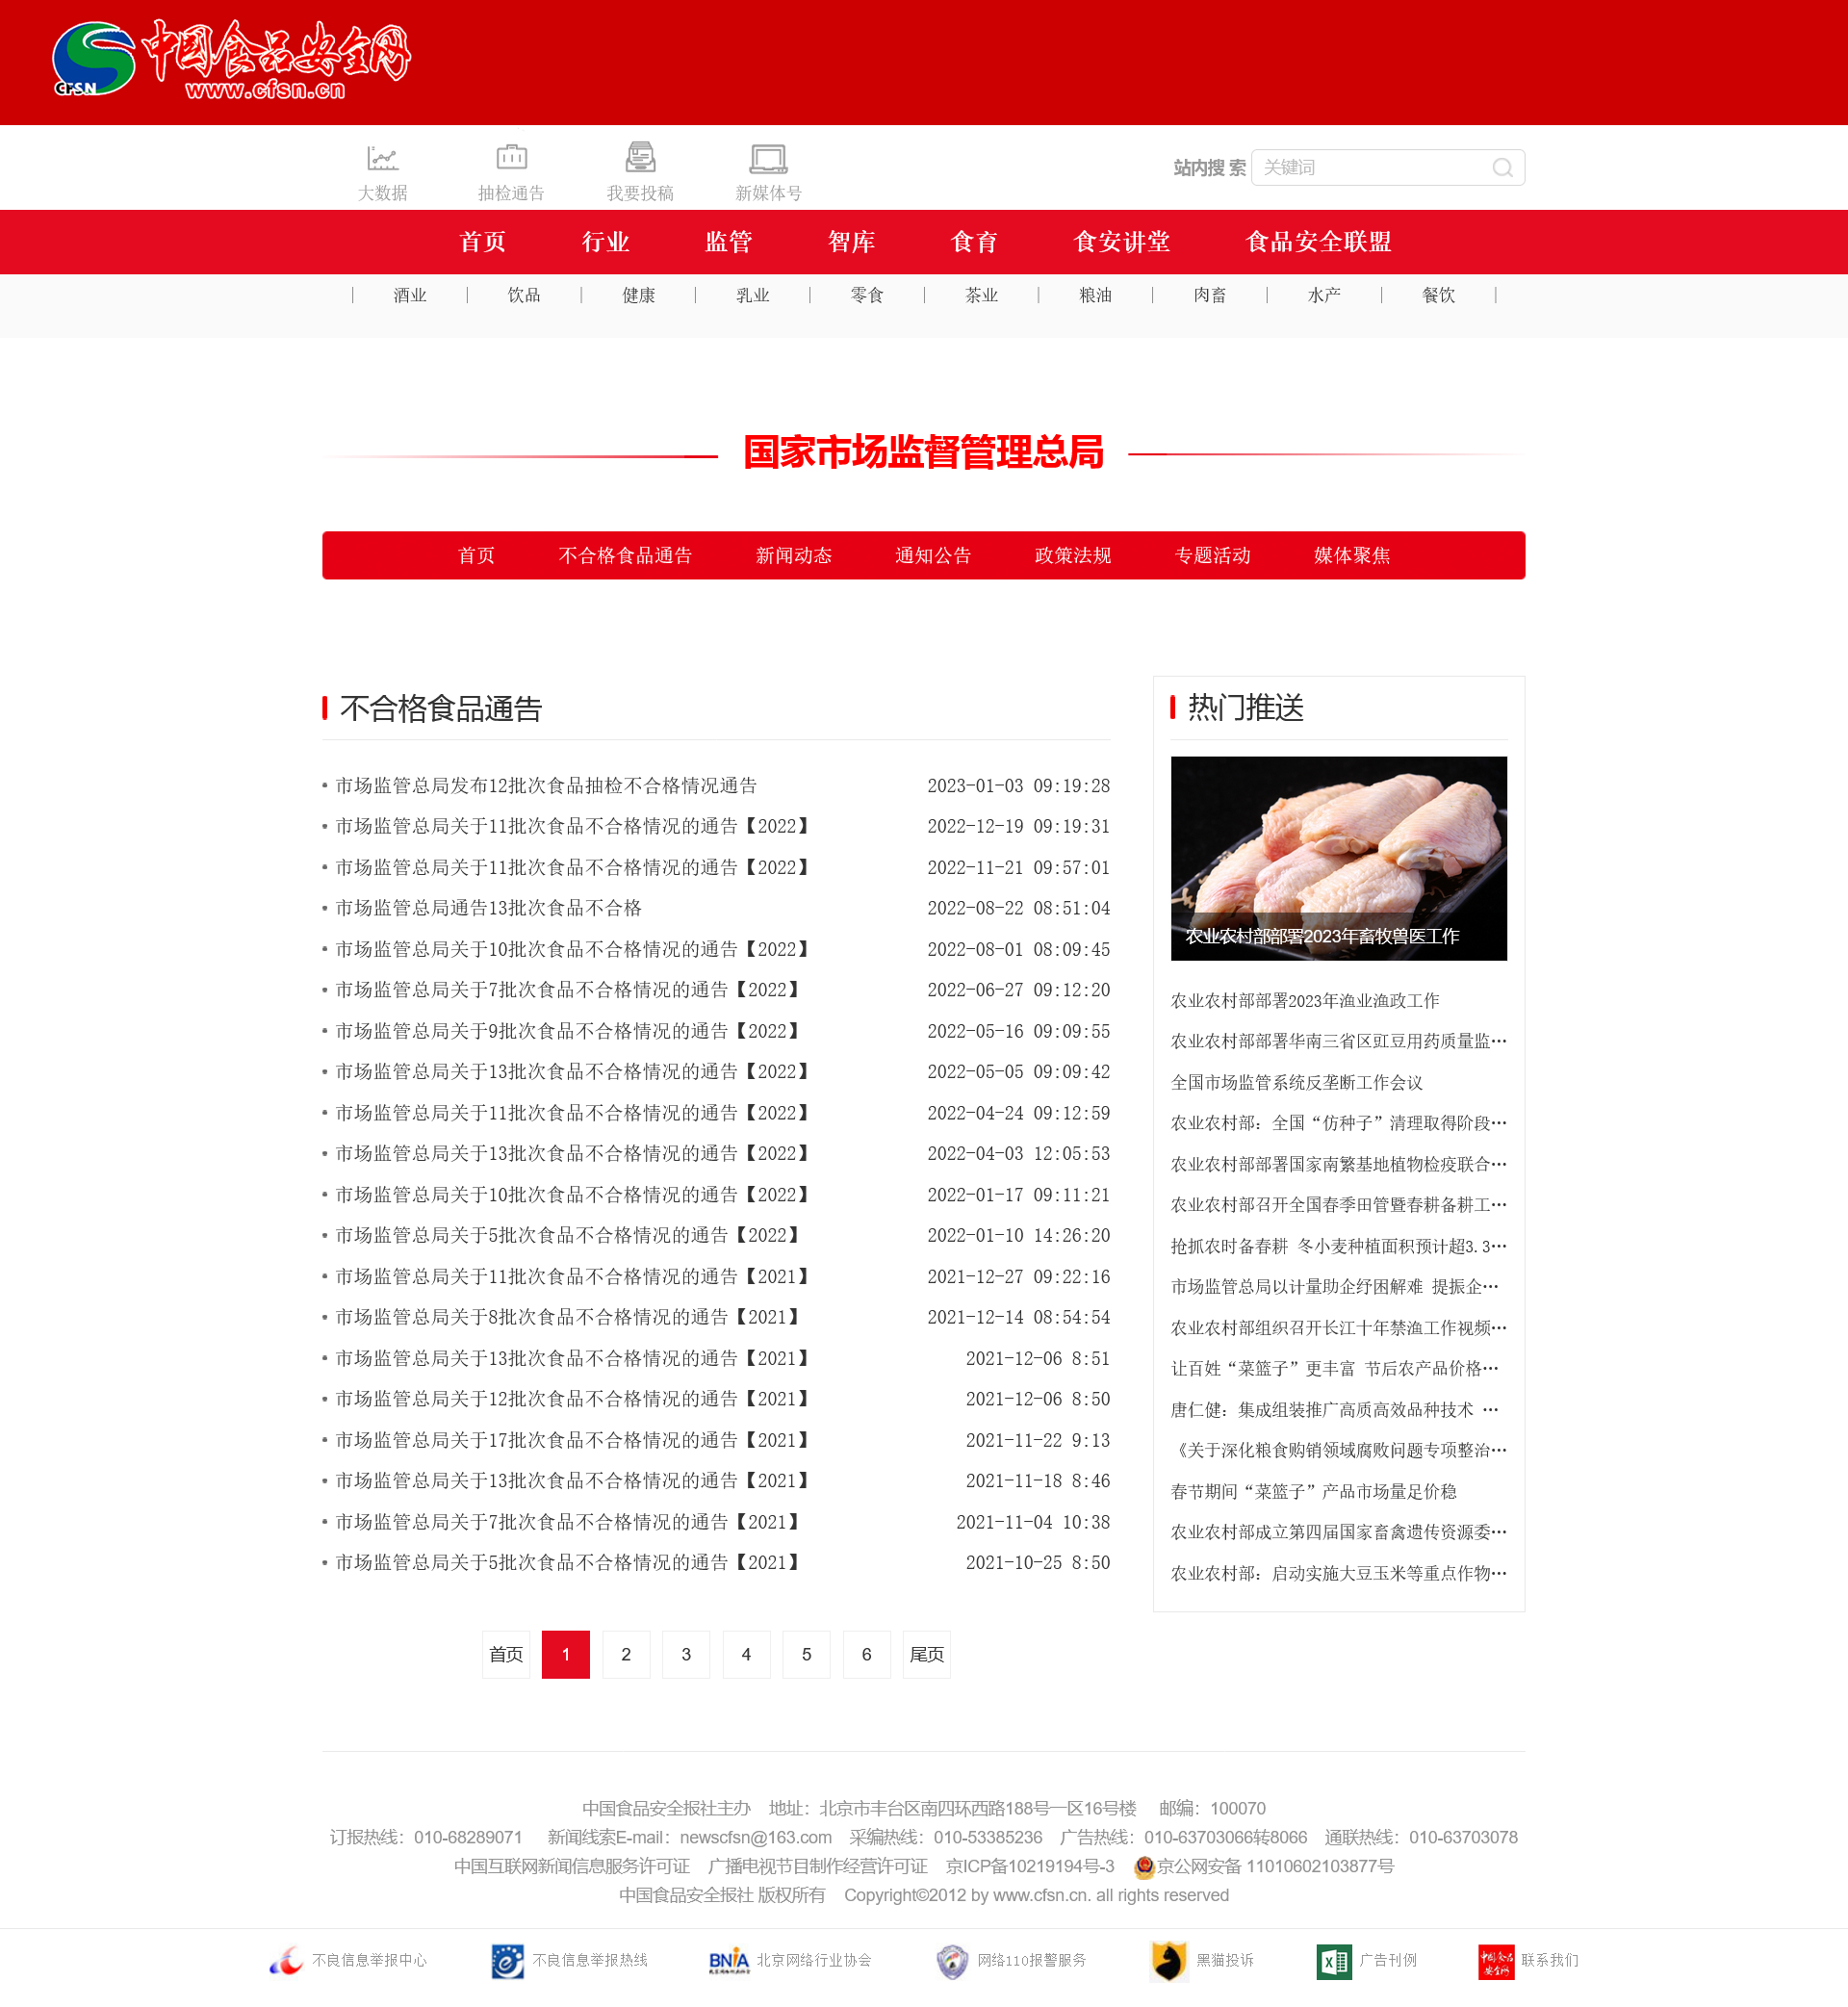

In [11]:
from datetime import datetime
fname = datetime.now().strftime('%Y%m%d%H%M%S')

df = spider('https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1', 10000, 'https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=')
# for url in ['http://www.cfsn.cn/news/node_4534_2.htm', 'http://www.cfsn.cn/news/node_4534_3.htm', 'http://www.cfsn.cn/news/node_4534_4.htm', 'http://www.cfsn.cn/news/node_4534_5.htm']:
#    df_tmp = spider(url, 10000, 'http://www.cfsn.cn/news/content/20')
#    df = pd.concat([df, df_tmp], ignore_index=True)

with pd.HDFStore(fname + '.h5',  mode='w') as store:
    store.append('df', df, data_columns= df.columns, format='table')

1 Visiting: https://www.cfsn.cn/front/web/site.bwnews
 **Success!**


## 中国食品安全网 - 专家解读专栏

In [22]:
from datetime import datetime
fname = datetime.now().strftime('%Y%m%d%H%M%S')

df = spider('http://www.cfsn.cn/zhuanti/node_5253.htm', 1000, 'http://www.cfsn.cn/zhuanti/20')

with pd.HDFStore(fname + '.h5',  mode='w') as store:
    store.append('df', df, data_columns= df.columns, format='table')

1 Visiting: http://www.cfsn.cn/zhuanti/node_5253.htm
 **Success!**
2 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84203.htm
 **Success!**
3 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84204.htm
 **Success!**
4 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84211.htm
 **Success!**
5 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84212.htm
 **Success!**
6 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84217.htm
 **Success!**
7 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84218.htm
 **Success!**
8 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84221.htm
 **Success!**
9 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84222.htm
 **Success!**
10 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84225.htm
 **Success!**
11 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84226.htm
 **Success!**
12 Visiting: http://www.cfsn.cn/zhuanti/2013-01/06/content_84229.htm
 **Success!**
13 Visiting: http://www.cfsn

C:\Users\penguin\Anaconda3\Lib\site-packages\tables\leaf.py:386: PerformanceWarning: The Leaf ``/df/_i_table/content/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [23]:
df

,url,date,title,content
23,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n “螺旋藻铅超标”热点概况\r\n,\n\n2012年3月，据中国之声《新闻晚高峰》报道，包括绿A公司在内的6大螺旋藻品牌被媒体...
22,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n 专家观点\r\n,\n\n北京大学工学院食品与生物资源工程研究所所长 陈峰\n螺旋藻是最受欢迎的藻类保健食品之...
21,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n “明胶门”热点概况\r\n,\n\n2012年4月9日，央视某主持人发微博称：“来自调查记者短信：不要再吃老酸奶（固体形...
20,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n 专家观点\r\n,\n\n中国食品发酵工业研究院前院长国家食品药品监督管理局特邀专家 孙熲\n食用明胶的标准中...
19,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n “立顿农药门”热点概况\r\n,\n\n“绿色和平组织”于2012年3月对全球最大的茶叶品牌——“立顿”牌袋泡茶叶进行了抽样...
18,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n 专家观点\r\n,\n\n江南大学食品学院院长 陈卫\n根据我国国家标准GB/T24690-2009“袋泡茶”...
17,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n “可口可乐含氯门”热点概况\r\n,\n\n2012年4月16日，有媒体报道披露，可口可乐山西饮料公司因管道改造，致使消毒用的含...
16,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n 专家观点\r\n,\n\n中国工程院院士，\n北京工商大学副校长，CIFST副理事长 孙宝国\n这是一起典型的...
15,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n “古越龙山黄酒含有致癌物”热点概况\r\n,\n\n2012年6月15日，香港消费者委员会称浙江绍兴的两款黄酒中含有2A类可疑致癌物氨基...
14,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n 专家观点\r\n,\n\n中国食品发酵工业研究院教授级高工 熊正河\n氨基甲酸乙酯（简称，EC）是广泛存在于发...


## 食安网 > 食品安全专栏

In [ ]:
from datetime import datetime
fname = datetime.now().strftime('%Y%m%d%H%M%S')

df = spider('http://www.cnfoodsafety.com/news/spaq/', 100000, 'http://www.cnfoodsafety.com/20')

with pd.HDFStore(fname + '.h5',  mode='w') as store:
    store.append('df', df, data_columns= df.columns, format='table')

1 Visiting: http://www.cnfoodsafety.com/news/spaq/
 **Success!**
2 Visiting: http://www.cnfoodsafety.com/2022/1231/68968.html
 **Success!**
3 Visiting: http://www.cnfoodsafety.com/2022/1231/68967.html
 **Success!**
4 Visiting: http://www.cnfoodsafety.com/2022/1231/68966.html
 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2022/1210/68783.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2022/1210/68782.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2022/1210/68781.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2022/0920/67796.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2022/0920/67795.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2022/0919/67783.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2022/0919/67784.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2022/0913/67692.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2022/0824/67361.html
 **Success!**
14 Visiting: http://www.cnfoods

 **Success!**
110 Visiting: http://www.cnfoodsafety.com/2014/0616/137.html
 **Success!**
111 Visiting: http://www.cnfoodsafety.com/2014/0616/147.html
 **Success!**
112 Visiting: http://www.cnfoodsafety.com/2014/1124/6633.html
 **Success!**
113 Visiting: http://www.cnfoodsafety.com/2014/1128/6928.html
 **Success!**
114 Visiting: http://www.cnfoodsafety.com/2015/0311/9458.html
 **Success!**
115 Visiting: http://www.cnfoodsafety.com/2016/0722/19552.html
 **Success!**
116 Visiting: http://www.cnfoodsafety.com/2017/0322/22791.html
 **Success!**
117 Visiting: http://www.cnfoodsafety.com/2014/0902/3245.html
 **Success!**
118 Visiting: http://www.cnfoodsafety.com/2014/1022/5339.html
 **Success!**
119 Visiting: http://www.cnfoodsafety.com/2014/1105/5868.html
 **Success!**
120 Visiting: http://www.cnfoodsafety.com/2014/1202/7033.html
 **Success!**
121 Visiting: http://www.cnfoodsafety.com/2015/0324/9872.html
 **Success!**
122 Visiting: http://www.cnfoodsafety.com/2021/0729/59177.html
 **Success!

 **Success!**
217 Visiting: http://www.cnfoodsafety.com/2016/1027/20985.html
 **Success!**
218 Visiting: http://www.cnfoodsafety.com/2016/1027/20983.html
 **Success!**
219 Visiting: http://www.cnfoodsafety.com/2014/0617/277.html
 **Success!**
220 Visiting: http://www.cnfoodsafety.com/2014/0617/278.html
 **Success!**
221 Visiting: http://www.cnfoodsafety.com/2014/1230/8109.html
 **Success!**
222 Visiting: http://www.cnfoodsafety.com/2014/1124/6618.html
 **Success!**
223 Visiting: http://www.cnfoodsafety.com/2014/0626/887.html
 **Success!**
224 Visiting: http://www.cnfoodsafety.com/2017/0307/22653.html
 **Success!**
225 Visiting: http://www.cnfoodsafety.com/2017/0307/22652.html
 **Success!**
226 Visiting: http://www.cnfoodsafety.com/2017/0103/21961.html
 **Success!**
227 Visiting: http://www.cnfoodsafety.com/2016/1230/21953.html
 **Success!**
228 Visiting: http://www.cnfoodsafety.com/2016/1229/21951.html
 **Success!**
229 Visiting: http://www.cnfoodsafety.com/2016/1221/21871.html
 **Succ

 **Success!**
324 Visiting: http://www.cnfoodsafety.com/2018/1018/32854.html
 **Success!**
325 Visiting: http://www.cnfoodsafety.com/2018/1016/32695.html
 **Success!**
326 Visiting: http://www.cnfoodsafety.com/2018/1009/32353.html
 **Success!**
327 Visiting: http://www.cnfoodsafety.com/2014/1013/4995.html
 **Success!**
328 Visiting: http://www.cnfoodsafety.com/2016/0226/17301.html
 **Success!**
329 Visiting: http://www.cnfoodsafety.com/2018/0118/25923.html
 **Success!**
330 Visiting: http://www.cnfoodsafety.com/2014/0616/24.html
 **Success!**
331 Visiting: http://www.cnfoodsafety.com/2014/0616/27.html
 **Success!**
332 Visiting: http://www.cnfoodsafety.com/2014/0616/82.html
 **Success!**
333 Visiting: http://www.cnfoodsafety.com/2014/0704/1039.html
 **Success!**
334 Visiting: http://www.cnfoodsafety.com/2014/0711/1201.html
 **Success!**
335 Visiting: http://www.cnfoodsafety.com/2014/0716/1262.html
 **Success!**
336 Visiting: http://www.cnfoodsafety.com/2014/0723/1425.html
 **Success!**

 **Success!**
432 Visiting: http://www.cnfoodsafety.com/2014/0616/6.html
 **Success!**
433 Visiting: http://www.cnfoodsafety.com/2014/0616/12.html
 **Success!**
434 Visiting: http://www.cnfoodsafety.com/2014/0616/13.html
 **Success!**
435 Visiting: http://www.cnfoodsafety.com/2014/0616/14.html
 **Success!**
436 Visiting: http://www.cnfoodsafety.com/2014/0616/15.html
 **Success!**
437 Visiting: http://www.cnfoodsafety.com/2018/0528/27241.html
 **Success!**
438 Visiting: http://www.cnfoodsafety.com/2014/1121/6556.html
 **Success!**
439 Visiting: http://www.cnfoodsafety.com/2015/0409/10350.html
 **Success!**
440 Visiting: http://www.cnfoodsafety.com/2018/0326/26539.html
 **Success!**
441 Visiting: http://www.cnfoodsafety.com/2017/0725/23972.html
 **Success!**
442 Visiting: http://www.cnfoodsafety.com/2014/0721/1348.html
 **Success!**
443 Visiting: http://www.cnfoodsafety.com/2015/0626/12611.html
 **Success!**
444 Visiting: http://www.cnfoodsafety.com/2017/0927/24769.html
 **Success!**
445

 **Success!**
540 Visiting: http://www.cnfoodsafety.com/2014/0617/424.html
 **Success!**
541 Visiting: http://www.cnfoodsafety.com/2014/0617/426.html
 **Success!**
542 Visiting: http://www.cnfoodsafety.com/2014/0617/428.html
 **Success!**
543 Visiting: http://www.cnfoodsafety.com/2014/0617/429.html
 **Success!**
544 Visiting: http://www.cnfoodsafety.com/2014/0903/3263.html
 **Success!**
545 Visiting: http://www.cnfoodsafety.com/2014/0617/413.html
 **Success!**
546 Visiting: http://www.cnfoodsafety.com/2014/0617/416.html
 **Success!**
547 Visiting: http://www.cnfoodsafety.com/2014/0617/417.html
 **Success!**
548 Visiting: http://www.cnfoodsafety.com/2014/0617/418.html
 **Success!**
549 Visiting: http://www.cnfoodsafety.com/2014/0616/35.html
 **Success!**
550 Visiting: http://www.cnfoodsafety.com/2016/1207/21687.html
 **Success!**
551 Visiting: http://www.cnfoodsafety.com/2018/0925/31884.html
 **Success!**
552 Visiting: http://www.cnfoodsafety.com/2018/0912/31152.html
 **Success!**
553 V

 **Success!**
648 Visiting: http://www.cnfoodsafety.com/2014/0806/2041.html
 **Success!**
649 Visiting: http://www.cnfoodsafety.com/2014/0811/2246.html
 **Success!**
650 Visiting: http://www.cnfoodsafety.com/2014/0910/3634.html
 **Success!**
651 Visiting: http://www.cnfoodsafety.com/2014/1011/4982.html
 **Success!**
652 Visiting: http://www.cnfoodsafety.com/2016/1009/20750.html
 **Success!**
653 Visiting: http://www.cnfoodsafety.com/2016/0926/20593.html
 **Success!**
654 Visiting: http://www.cnfoodsafety.com/2016/0921/20488.html
 **Success!**
655 Visiting: http://www.cnfoodsafety.com/2014/0616/60.html
 **Success!**
656 Visiting: http://www.cnfoodsafety.com/2014/0616/74.html
 **Success!**
657 Visiting: http://www.cnfoodsafety.com/2014/0616/75.html
 **Success!**
658 Visiting: http://www.cnfoodsafety.com/2014/0616/80.html
 **Success!**
659 Visiting: http://www.cnfoodsafety.com/2014/0711/1200.html
 **Success!**
660 Visiting: http://www.cnfoodsafety.com/2014/1209/7362.html
 **Success!**
661

 **Success!**
756 Visiting: http://www.cnfoodsafety.com/2014/0929/4667.html
 **Success!**
757 Visiting: http://www.cnfoodsafety.com/2015/0507/11003.html
 **Success!**
758 Visiting: http://www.cnfoodsafety.com/2016/1111/21327.html
 **Success!**
759 Visiting: http://www.cnfoodsafety.com/2014/0626/864.html
 **Success!**
760 Visiting: http://www.cnfoodsafety.com/2015/0722/13215.html
 **Success!**
761 Visiting: http://www.cnfoodsafety.com/2016/1121/21439.html
 **Success!**
762 Visiting: http://www.cnfoodsafety.com/2018/0207/26183.html
 **Success!**
763 Visiting: http://www.cnfoodsafety.com/2014/0912/3778.html
 **Success!**
764 Visiting: http://www.cnfoodsafety.com/2016/0107/16634.html
 **Success!**
765 Visiting: http://www.cnfoodsafety.com/2016/1221/21876.html
 **Success!**
766 Visiting: http://www.cnfoodsafety.com/2015/0929/15003.html
 **Success!**
767 Visiting: http://www.cnfoodsafety.com/2016/0121/16871.html
 **Success!**
768 Visiting: http://www.cnfoodsafety.com/2016/0419/18130.html
 **

 **Success!**
864 Visiting: http://www.cnfoodsafety.com/2017/0315/22719.html
 **Success!**
865 Visiting: http://www.cnfoodsafety.com/2017/0720/23906.html
 **Success!**
866 Visiting: http://www.cnfoodsafety.com/2017/1025/25089.html
 **Success!**
867 Visiting: http://www.cnfoodsafety.com/2017/1124/25402.html
 **Success!**
868 Visiting: http://www.cnfoodsafety.com/2016/1220/21813.html
 **Success!**
869 Visiting: http://www.cnfoodsafety.com/2017/0113/22035.html
 **Success!**
870 Visiting: http://www.cnfoodsafety.com/2017/0120/22120.html
 **Success!**
871 Visiting: http://www.cnfoodsafety.com/2017/0512/23273.html
 **Success!**
872 Visiting: http://www.cnfoodsafety.com/2014/1128/6934.html
 **Success!**
873 Visiting: http://www.cnfoodsafety.com/2015/0515/11299.html
 **Success!**
874 Visiting: http://www.cnfoodsafety.com/2016/0801/19730.html
 **Success!**
875 Visiting: http://www.cnfoodsafety.com/2016/0801/19731.html
 **Success!**
876 Visiting: http://www.cnfoodsafety.com/2017/1228/25793.html


 **Success!**
972 Visiting: http://www.cnfoodsafety.com/2014/0915/3881.html
 **Success!**
973 Visiting: http://www.cnfoodsafety.com/2014/1223/7811.html
 **Success!**
974 Visiting: http://www.cnfoodsafety.com/2015/0327/10063.html
 **Success!**
975 Visiting: http://www.cnfoodsafety.com/2015/0429/10858.html
 **Success!**
976 Visiting: http://www.cnfoodsafety.com/2014/0915/3863.html
 **Success!**
977 Visiting: http://www.cnfoodsafety.com/2014/1120/6504.html
 **Success!**
978 Visiting: http://www.cnfoodsafety.com/2014/1210/7394.html
 **Success!**
979 Visiting: http://www.cnfoodsafety.com/2015/0331/10164.html
 **Success!**
980 Visiting: http://www.cnfoodsafety.com/2018/0905/30702.html
 **Success!**
981 Visiting: http://www.cnfoodsafety.com/2018/0906/30789.html
 **Success!**
982 Visiting: http://www.cnfoodsafety.com/2018/0905/30699.html
 **Success!**
983 Visiting: http://www.cnfoodsafety.com/2014/0617/170.html
 **Success!**
984 Visiting: http://www.cnfoodsafety.com/2018/0721/28654.html
 **Suc

 **Success!**
1079 Visiting: http://www.cnfoodsafety.com/2014/1031/5715.html
 **Success!**
1080 Visiting: http://www.cnfoodsafety.com/2014/1128/6912.html
 **Success!**
1081 Visiting: http://www.cnfoodsafety.com/2014/0616/77.html
 **Success!**
1082 Visiting: http://www.cnfoodsafety.com/2014/0616/79.html
 **Success!**
1083 Visiting: http://www.cnfoodsafety.com/2014/0626/852.html
 **Success!**
1084 Visiting: http://www.cnfoodsafety.com/2015/0202/8795.html
 **Success!**
1085 Visiting: http://www.cnfoodsafety.com/2015/0209/8905.html
 **Success!**
1086 Visiting: http://www.cnfoodsafety.com/2015/0519/11380.html
 **Success!**
1087 Visiting: http://www.cnfoodsafety.com/2014/0616/84.html
 **Success!**
1088 Visiting: http://www.cnfoodsafety.com/2015/0319/9704.html
 **Success!**
1089 Visiting: http://www.cnfoodsafety.com/2015/0408/10307.html
 **Success!**
1090 Visiting: http://www.cnfoodsafety.com/2015/0115/8402.html
 **Success!**
1091 Visiting: http://www.cnfoodsafety.com/2015/0526/11660.html
 **

 **Success!**
1186 Visiting: http://www.cnfoodsafety.com/2015/0925/14921.html
 **Success!**
1187 Visiting: http://www.cnfoodsafety.com/2018/0808/29325.html
 **Success!**
1188 Visiting: http://www.cnfoodsafety.com/2017/0729/24093.html
 **Success!**
1189 Visiting: http://www.cnfoodsafety.com/2018/0202/26104.html
 **Success!**
1190 Visiting: http://www.cnfoodsafety.com/2018/0313/26430.html
 **Success!**
1191 Visiting: http://www.cnfoodsafety.com/2018/1012/32524.html
 **Success!**
1192 Visiting: http://www.cnfoodsafety.com/2017/0725/23955.html
 **Success!**
1193 Visiting: http://www.cnfoodsafety.com/2015/0306/9385.html
 **Success!**
1194 Visiting: http://www.cnfoodsafety.com/2015/0402/10221.html
 **Success!**
1195 Visiting: http://www.cnfoodsafety.com/2015/0601/11876.html
 **Success!**
1196 Visiting: http://www.cnfoodsafety.com/2015/0902/14488.html
 **Success!**
1197 Visiting: http://www.cnfoodsafety.com/2018/0301/26323.html
 **Success!**
1198 Visiting: http://www.cnfoodsafety.com/2018/032

### 读取数据

In [1]:
import pandas as pd

with pd.HDFStore('20180504234042.h5',  mode='r') as newstore:
    df_restored = newstore.select('df')

C:\Users\penguin\Anaconda3\Lib\site-packages\tables\leaf.py:386: PerformanceWarning: The Leaf ``/df/_i_table/content/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


### PYNIPIR(ICTCLAS - Institute of Computing Technology，Chinese Lexical Analysis System)

> pip install pynlpir   
> pynlpir update

In [19]:
import pynlpir  # 引入依赖包
pynlpir.open()  # 打开分词器

from ctypes import c_char_p
pynlpir.nlpir.AddUserWord(c_char_p("食品安全".encode()))

for item in df_restored.values[:5]:
    print(item[2], '\t', pynlpir.segment(item[2], pos_english=False, pos_tagging=True), '\n', pynlpir.get_key_words(item[3]), '\n\n')
    
pynlpir.close()

dir(pynlpir)

山东省高级人民法院公布四起典型案例 	 [('山东省', '名词'), ('高级', '形容词'), ('人民法院', '名词'), ('公布', '动词'), ('四', '数词'), ('起', '量词'), ('典型', '名词'), ('案例', '名词')] 
 ['姜宏战', '张占', '被告人', '销售', '生产', '有期徒刑', '食品', '工业明胶', '刘明光', '人民群众', '煮胶', '非法经营罪', '祁志华', '判处被告人', '原料', '审判', '工作', '法院', '食品罪', '食品安全', '国家规定', '用于', '犯罪', '使用', '情节', '王庆荣', '经营', '人民', '危害', '武城县', '工业', '国家', '添加', '硫酸', '严重', '上诉', '社会', '刑罚', '职能', '参与', '餐桌', '提供', '违反', '禁止', '明知', '活动', '收购', '组织', '蒸锅', '负责'] 


青岛公布危害食药安全犯罪典型案例 	 [('青岛', '名词'), ('公布', '动词'), ('危害', '动词'), ('食', '动词'), ('药', '名词'), ('安全', '形容词'), ('犯罪', '动词'), ('典型', '名词'), ('案例', '名词')] 
 ['销售', '高某', '赵某', '加工', '牛肚', '生产', '使用', '食品', '对外销售', '进行', '甲醛', '成分', '屠宰', '大葱', '国家', '经营', '盐产品', '非食品原料', '明知', '判处有期徒刑', '松香', '白菜', '收购', '添加', '生猪', '含有', '保健食品', '原料', '非食用', '工业', '销售金额', '胡某', '工业松香', '屠宰生猪', '使用国家', '食用', '扣押', '禁止', '粮食', '食品罪', '巴西', '构成', '有期徒刑', '产品', '制品', '有毒', '检测', '安排', '物质', '火碱'] 


食品微生物快速检测技术研究 	 [('食品', '名词'), ('微生物', '名词'), ('快速', '区别词'), 

['ENCODING',
 'ENCODING_ERRORS',
 'LicenseError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_attempt_to_raise_license_error',
 '_decode',
 '_encode',
 '_get_pos_name',
 '_to_float',
 'close',
 'dt',
 'fopen',
 'get_key_words',
 'is_python3',
 'logger',
 'logging',
 'nlpir',
 'open',
 'os',
 'pos_map',
 'segment',
 'sys',
 'unicode',
 'unicode_literals']

### SnowNLP

In [54]:
from snownlp import SnowNLP

for item in df_restored.values[:10]:
    s = SnowNLP(item[3])
    print(item[2], '\t', s.keywords(5), '\n', s.summary(3), '\n\n')

山东省高级人民法院公布四起典型案例 	 ['被告人', '销售', '生产', '食品', '人'] 
 ['以生产、销售不符合安全标准的食品罪分别判处被告人宋振有期徒刑三年', '以生产、销售有毒、有害食品罪分别判处被告人王庆荣有期徒刑十年', '以生产、销售有毒、有害食品罪、非法经营罪分别判处被告人姜宏战有期徒刑十四年、一年'] 


青岛公布危害食药安全犯罪典型案例 	 ['销售', '某某', '中', '食品', '案例'] 
 ['马某某犯生产、销售有毒、有害食品罪', '董某某在生产、销售的食品中掺入有毒、有害的非食品原料', '迟某某在生产、销售的食品中掺入有毒、有害的非法食品原料'] 


食品微生物快速检测技术研究 	 ['检测', '技术', '方法', '中', '扩'] 
 ['核酸依赖性扩增检测技术核酸依赖性扩增检测技术（NASBA）是一项以RNA模板进行等温核酸扩增并能实时监测结果的检测方法', '普通PCR PCR技术被广泛用于各类食品中致病菌及毒素的检测', '非PCR核酸检测技术'] 


检测实验室申请认可的关键环节 	 ['实验室', '认可', '检测', '质量', '文件'] 
 ['基本认可准则即CNAS-CL01《检测和校准实验室能力认可准则》', '确定申请认可的检测对象、检测项目、检测方法', '按照CNAS认可准则的要求建立管理体系'] 


甜酒酿的制作 	 ['中', '糯米', '酒', '酿', '发酵'] 
 ['另外甜酒酿中这些氨基酸含量虽然不是很高', '发酵好的甜酒酿从生化培养箱中拿出', '酒酿中的脂肪含量很低'] 


液相串联质谱法测定饮用水中甲醛 	 ['甲醛', '质', '溶液', '谱', '离子'] 
 ['本实验采用乙腈+0.1%甲酸水溶液体系作为流动相', '衍生后液相串联质谱仪测定', '液相串联质谱法测定饮用水中的甲醛'] 


食品安全分析方法的研究 	 ['分析', '食品', '法', '测定', '高'] 
 ['荧光分析法的好处是灵敏度高', '荧光分光光度法方法的选择性较分光光度法有所提高', '在计算机技术和联用技术（如质谱核磁共振波谱）的发展下,有着高灵敏度、高质量、高效率特点的高效液相技术的应用将越来越广泛'] 


药品微生物限度检查和食品微生物检验的

In [7]:
from snownlp import SnowNLP

s = SnowNLP(u'这个东西真心很赞')

print(s.words)         # [u'这个', u'东西', u'真心',
                #  u'很', u'赞']

print(s.sentiments)    # 0.9769663402895832 positive的概率

print(s.pinyin)        # [u'zhe', u'ge', u'dong', u'xi',
                #  u'zhen', u'xin', u'hen', u'zan']

['这个', '东西', '真心', '很', '赞']
0.9769551298267365
['zhe', 'ge', 'dong', 'xi', 'zhen', 'xin', 'hen', 'zan']


In [15]:
for tag in s.tags:
    print(tag)

('这个', 'r')
('东西', 'n')
('真心', 'd')
('很', 'd')
('赞', 'Vg')


In [4]:
s = SnowNLP(u'「繁體字」「繁體中文」的叫法在臺灣亦很常見。')

s.han           # u'「繁体字」「繁体中文」的叫法
                # 在台湾亦很常见。'

'「繁体字」「繁体中文」的叫法在台湾亦很常见。'

In [19]:
text = u'''
自然语言处理是计算机科学领域与人工智能领域中的一个重要方向。
它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法。
自然语言处理是一门融语言学、计算机科学、数学于一体的科学。
因此，这一领域的研究将涉及自然语言，即人们日常使用的语言，
所以它与语言学的研究有着密切的联系，但又有重要的区别。
自然语言处理并不是一般地研究自然语言，
而在于研制能有效地实现自然语言通信的计算机系统，
特别是其中的软件系统。因而它是计算机科学的一部分。
'''

s = SnowNLP(text)

print(s.keywords(3))

print(s.summary(2))

print(s.sentences)

['语言', '自然', '计算机']
['因而它是计算机科学的一部分', '自然语言处理是计算机科学领域与人工智能领域中的一个重要方向']
['自然语言处理是计算机科学领域与人工智能领域中的一个重要方向', '它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法', '自然语言处理是一门融语言学、计算机科学、数学于一体的科学', '因此', '这一领域的研究将涉及自然语言', '即人们日常使用的语言', '所以它与语言学的研究有着密切的联系', '但又有重要的区别', '自然语言处理并不是一般地研究自然语言', '而在于研制能有效地实现自然语言通信的计算机系统', '特别是其中的软件系统', '因而它是计算机科学的一部分']
